In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import datetime

sns.set_theme("notebook")
%matplotlib inline

### Chargement des données, séparé par machine

In [2]:
df = pd.read_csv("../../data/prepared_data/dataset.csv")

df_by_machine = df.groupby("machineID")

##### Age et nombre de défaillances par type de machine

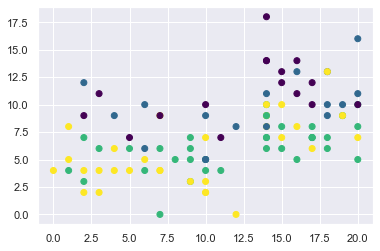

In [3]:
data=[]
ages=[]
modeles =[]
for i in range(1,100):
    df_machine = df_by_machine.get_group(i)
    ages.append(df_machine["age"].values[0])
    modeles.append(int(df_machine["model"].values[0][5]))
    data.append(df_machine["total_failure"].sum())
plt.scatter(ages,data,c=modeles,cmap='viridis')

In [4]:
telemetry_df=df[['volt_mean', 'volt_std', 'rotate_mean', 'rotate_std','pressure_mean', 'pressure_std', 'vibration_mean', 'vibration_std','comp1', 'comp2', 'comp3', 'comp4', 'total_failure']]

<AxesSubplot:>

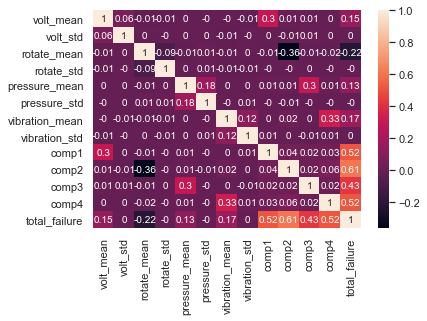

In [5]:
matrix = telemetry_df.corr().round(2)
sns.heatmap(matrix, annot=True)

On observe les corrélations suivantes entre la télémétrie et les défaillances: 
    - Volt_mean avec Comp1, 
    - Rotate_mean avec Comp2 (négativement), 
    - Pressure_mean avec Comp3,
    - Vibration_mean avec Comp4

### Visualisation des corrélations détectées

Coloriage par modèle de machine

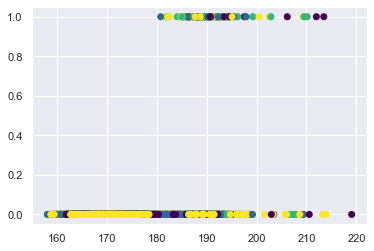

In [6]:
def model_number(name):
    return int(name[5])


plt.scatter(df['volt_mean'],df['comp1'],c=df['model'].map(model_number),cmap='viridis')

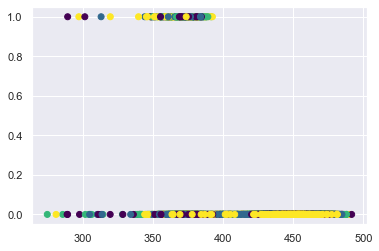

In [7]:
plt.scatter(df['rotate_mean'],df['comp2'],c=df['model'].map(model_number),cmap='viridis')

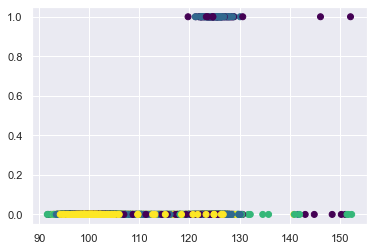

In [8]:
plt.scatter(df['pressure_mean'],df['comp3'],c=df['model'].map(model_number),cmap='viridis')

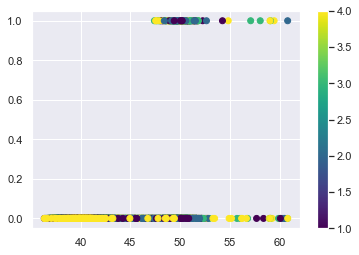

In [9]:
plt.scatter(df['vibration_mean'],df['comp4'],c=df['model'].map(model_number),cmap='viridis')
plt.colorbar()

Coloriage par defaillance, représentation par age du composant

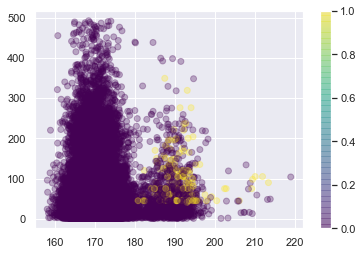

In [10]:
plt.scatter(df['volt_mean'],df['comp1_delay'],c=df['comp1'],cmap='viridis', alpha=0.3)
plt.colorbar()

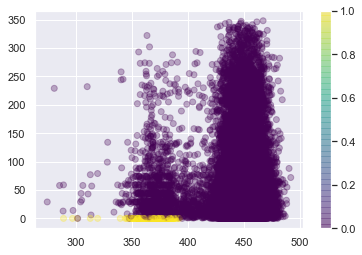

In [28]:
plt.scatter(df['rotate_mean'],df['comp2_delay'],c=df['comp2'],cmap='viridis', alpha=0.3)
plt.colorbar()

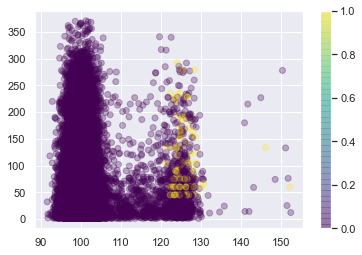

In [11]:
plt.scatter(df['pressure_mean'],df['comp3_delay'],c=df['comp3'],cmap='viridis', alpha=0.3)
plt.colorbar()

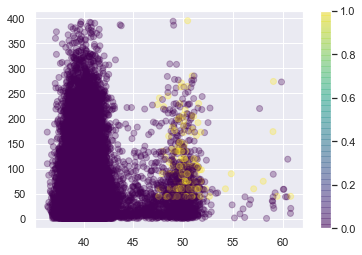

In [12]:
plt.scatter(df['vibration_mean'],df['comp4_delay'],c=df['comp4'],cmap='viridis', alpha=0.3)
plt.colorbar()